In [ ]:
import time

import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn
import torch.optim as optim
from metrics import *
from utilty import *
from load_data import *
from model import *

import warnings
warnings.filterwarnings("ignore")

random.seed(2022)
np.random.seed(2022)
torch.manual_seed(2022)

print(cmd_args)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

print("loading data...")

cmd_args.dataset = './OMIM/bigraph/cross1'
cmd_args.emb_dim = 200
cmd_args.layer_size = "[200]"
cmd_args.batch_size = 512
cmd_args.learning_rate = 0.005
cmd_args.dropout = 0.3
cmd_args.reg=0.001
cmd_args.gamma=0.1
cmd_args.alpha=3
cmd_args.beta=0.1
cmd_args.neg_num=5
cmd_args.k=0.5
cmd_args.Ks = [1,5,10,15]


data_generator = DataLoading(args=cmd_args)

torch.cuda.set_device(gm.auto_choice())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

user_embed = torch.ones([data_generator.n_users, cmd_args.emb_dim]).to(device)
item_embed = torch.ones([data_generator.n_items, cmd_args.emb_dim]).to(device)
torch.nn.init.xavier_uniform_(user_embed)
torch.nn.init.xavier_uniform_(item_embed)

init_embedding = dict()
entity_embed = torch.cat((user_embed, item_embed), 0)
init_embedding['entity_embedding'] = entity_embed

model = Model(data_config=data_generator.get_config(), args=cmd_args, init_embedding=init_embedding).to(device)

optimizer = optim.Adam(model.parameters(),
                           lr=cmd_args.learning_rate, 
                           amsgrad=True,
                           weight_decay=0.001)

stopping_step, runing_step = 20, 0
best_rec = 0
all_entities_id = torch.LongTensor(np.arange(data_generator.n_items + data_generator.n_users)).to(device)      
epoch = 0

Namespace(Ks=[1, 5, 10, 15], T=0.01, alpha=1, batch_size=128, beta=1, dataset='OMIM', dropout=0.1, emb_dim=64, gamma=0.1, gpu_id=-1, hid_dim=200, k=0.5, layer_size='[64]', learning_rate=0.0001, mi_batch_size=1000, mi_kind='infonce', neg_num=10, num_epochs=100, pretrain=None, reg=0.001, seed=0, show_model_param=False, show_step=1, type=3, weight=None)
2022-02-08 14:30:08
loading data...
231488
48602
[n_users, n_items]=[3209, 12211]
[n_train, n_test]=[2636, 1318]
[n_edges]=[280090]
Using GPU 0,  memory_free: 24265


In [2]:
def train(epoch, model, data_generator, cmd_args, optimizer) :
    logger.info("epoch: {}".format(epoch))
    """
    *********************************************************
    Train.
    """
    model.train()
    t1 = time.time()

    mi_loss = 0

    n_batch = data_generator.adj.shape[0] // cmd_args.mi_batch_size + 1
    pbar = tqdm(range(n_batch), unit='batch', ncols=120)
    optimizer.zero_grad()
    entity_embedding = model.Encode(all_entities_id)
    mi_sc = []
    for i in pbar:
        source, pos_target, neg_target = data_generator.generate_batch(i, cmd_args.mi_batch_size, cmd_args.neg_num)
        sc, pos, neg = model(data_generator.adj, data_generator.A, entity_embedding, batch=(i, source, pos_target, neg_target))
        batch_mi_loss = cmd_args.gamma * MI_loss(pos, neg, cmd_args.T, cmd_args.mi_kind)
        mi_loss += batch_mi_loss
        mi_sc.append(sc)
    sub = model.sort_MI(mi_sc, data_generator.adj)

    user_embed, item_embed = model(data_generator.adj, data_generator.A, entity_embedding, sub=sub)
    bpr_loss = BPR_loss(data_generator, user_embed, item_embed)
    loss = mi_loss + bpr_loss
    # loss.backward()

    # optimizer.step()

    t2 = time.time()
    """
    *********************************************************
    Test.
    """
    model.eval()

    ret = generate_result(len(cmd_args.Ks))

    test_users = list(data_generator.test_user_dict.keys())
    n_test_users = len(test_users)
    n_batch = n_test_users // cmd_args.batch_size + 1

    count = 0
    for id in range(n_batch):
        start = id * cmd_args.batch_size
        end = (id + 1) * cmd_args.batch_size
        user_batch = test_users[start: end]
        item_batch = range(data_generator.n_items)

        u_e, i_e = user_embed[user_batch], item_embed[item_batch]
        batch_predictions = torch.matmul(u_e, i_e.transpose(0,1)).cpu().detach().numpy()
        batch_result = batch_metrics(batch_predictions, user_batch, data_generator)

        count += len(batch_result)

        for re in batch_result:
            ret['precision'] += re['precision']/n_test_users
            ret['recall'] += re['recall']/n_test_users
            ret['ndcg'] += re['ndcg']/n_test_users
            ret['hit_ratio'] += re['hit_ratio']/n_test_users
            ret['auc'] += re['auc']/n_test_users
            ret['predict'][re['predict'][0]] = np.array(re['predict'])[1:]

    assert count == n_test_users

    t3 = time.time()
    show_step = cmd_args.show_step
    if (epoch + 1) % show_step == 0:
        np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
        # for i in range(show_step):
            # sys.stdout.write("\033[F")
        print('Epoch %d [%.1fs + %.1fs]: train==[%.5f = %.5f + %.5f], recall=' % (epoch, t2 - t1, t3 - t2, bpr_loss+mi_loss, bpr_loss, mi_loss) \
            , ret['recall'], ', precision=', ret['precision'] , ', auc=[%.5f], sum_recall=[%.5f]' % (ret['auc'], sum(ret['recall'])) \
        )
    return sub, user_embed, item_embed

In [3]:
cmd_args.mi_kind="js"
cmd_args.Ks = [1,5,10,15]
model.load_state_dict(torch.load('./test_model'))
for i in range(0,1):
    sub, uu, ee = train(i, model, data_generator, cmd_args, optimizer)


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.76s/batch]


Epoch 0 [30.8s + 11.6s]: train==[2.30794 = 0.08685 + 2.22109], recall= [ 0.03224  0.11503  0.17393  0.21625] , precision= [ 0.03501  0.02596  0.01973  0.01640] , auc=[0.82767], sum_recall=[0.53746]


In [5]:
model.eval()
ret = generate_result(len(cmd_args.Ks))

test_users = list(data_generator.test_user_dict.keys())
n_test_users = len(test_users)
n_batch = n_test_users // cmd_args.batch_size + 1

count = 0
test = []
for id in range(n_batch):
    start = id * cmd_args.batch_size
    end = (id + 1) * cmd_args.batch_size
    user_batch = test_users[start: end]
    item_batch = range(data_generator.n_items)

    u_e, i_e = uu[user_batch], ee[item_batch]
    batch_predictions = torch.matmul(u_e, i_e.transpose(0,1)).cpu().detach().numpy()
    batch_result = batch_metrics(batch_predictions, user_batch, data_generator)

    count += len(batch_result)

    for re in batch_result:
        test.append((re['predict'][0], re['auc']))
        ret['precision'] += re['precision']/n_test_users
        ret['recall'] += re['recall']/n_test_users
        ret['ndcg'] += re['ndcg']/n_test_users
        ret['hit_ratio'] += re['hit_ratio']/n_test_users
        ret['auc'] += re['auc']/n_test_users
        ret['predict'][re['predict'][0]] = np.array(re['predict'])[1:]
    
assert count == n_test_users

# test = sorted(test, key=lambda x:x[1], reverse=True)
# print(test)
print(ret['predict'][3115])
for i in ret['predict'][3115]:
    print(i[0] + 3209, i[1])

t3 = time.time()
show_step = cmd_args.show_step
if (epoch + 1) % show_step == 0:
    np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
    # for i in range(show_step):
        # sys.stdout.write("\033[F")
    print('Epoch %d [%.1fs + %.1fs]: train==[%.5f = %.5f + %.5f], recall=' % (epoch, 0, 0, 0+0, 0, 0) \
        , ret['recall'], ', precision=', ret['precision'] , ', auc=[%.5f], sum_recall=[%.5f]' % (ret['auc'], sum(ret['recall'])) \
    )

[list([3844, 3.9597325]) list([821, 3.520608]) list([822, 3.4765868])
 list([1389, 3.2791991]) list([9026, 3.1027365]) list([4209, 2.9461892])
 list([6146, 2.8898084]) list([5128, 2.8675077]) list([8727, 2.8407505])
 list([7510, 2.808065]) list([8192, 2.7704868, -1])
 list([1722, 2.7662754]) list([7559, 2.7568812]) list([5811, 2.752675])
 list([1579, 2.7227457])]
7053 3.9597325
4030 3.520608
4031 3.4765868
4598 3.2791991
12235 3.1027365
7418 2.9461892
9355 2.8898084
8337 2.8675077
11936 2.8407505
10719 2.808065
11401 2.7704868
4931 2.7662754
10768 2.7568812
9020 2.752675
4788 2.7227457
Epoch 0 [0.0s + 0.0s]: train==[0.00000 = 0.00000 + 0.00000], recall= [ 0.03224  0.11503  0.17393  0.21625] , precision= [ 0.03501  0.02596  0.01973  0.01640] , auc=[0.82767], sum_recall=[0.53746]


In [22]:
A = data_generator.adj + data_generator.A
def fff1(gene, disease):
    g1 = set(A.tocsr()[gene].tocoo().col)
    for g in g1:
        if A.tocsr()[g,disease] > 0:
                print(gene,g,disease)

    d1 = set(A.tocsr()[disease].tocoo().col)
    for d in d1:
        if A.tocsr()[d, gene] > 0:
                print(disease,d,gene)


def fff2(gene, disease):
    d1 = set(A.tocsr()[disease].tocoo().col)
    for d in d1:
        d2 = set(A.tocsr()[d].tocoo().col)
        for d_ in d2:
            if A.tocsr()[d_, gene] > 0:
                print(disease,d,d_,gene)
    g1 = set(A.tocsr()[gene].tocoo().col)
    for g in g1:
        g2 = set(A.tocsr()[g].tocoo().col)
        for g_ in g2:
            if A.tocsr()[g_,disease] > 0:
                print(gene,g,g_,disease)

    

def fff3(gene, disease):
    d1 = set(A.tocsr()[disease].tocoo().col)
    for d in d1:
        d2 = set(A.tocsr()[d].tocoo().col)
        for d_ in d2:
            d3 = set(A.tocsr()[d_].tocoo().col)
            for d__ in d3:
                if A.tocsr()[d__, gene] > 0:
                    print(disease,d,d_,d__,gene)
    g1 = set(A.tocsr()[gene].tocoo().col)
    for g in g1:
        g2 = set(A.tocsr()[g].tocoo().col)
        for g_ in g2:
            g3 = set(A.tocsr()[g_].tocoo().col)
            for g__ in g3:
                if A.tocsr()[g__,disease] > 0:
                    print(gene,g,g_,g__,disease)

    
# def fff4(gene, disease):
#     d1 = set(A.tocsr()[disease].tocoo().col)
#     for d in d1:
#         d2 = set(A.tocsr()[d].tocoo().col)
#         for d_ in d2:
#             d3 = set(A.tocsr()[d_].tocoo().col)
#             for d__ in d3:
#                 d4 = set(A.tocsr()[d__].tocoo().col)
#                 for d___ in d4:
#                     if data_generator.A.tocsr()[d___, gene] > 0:
#                         print(disease,d,d_,d__,gene)


d = 181
g = 6543
fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')
# print('----------------------------------------------------')
# g = 6543
# fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')
# print('----------------------------------------------------')
# g = 11373
# fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')
# print('----------------------------------------------------')
# g = 11373
# d = 6543
# fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')
# print('----------------------------------------------------')
# g = 11373
# d = 7203
# fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')
# print('----------------------------------------------------')
# g = 6534
# d = 7203
# fff1(g, d)
# fff2(g, d)
# fff3(g, d)
# print(d,g,'end')

In [20]:


ind, val, ind1, val1 = sub[0], sub[1], sub[2], sub[3]
g1 = 24
g2 = 7203
g3 = 6543
g4 = 11373
print('infomative neighbors: ')
for i in range(len(val)):
    if ind[1][i] == g1:
        print(ind[0][i], ind[1][i], val[i])
print('--------------------------------------------------------')
print('all neighbors: ')
for i in range(len(val1)):
    if ind1[1][i] == g1:
        print(ind1[0][i], ind1[1][i], val1[i])
print('------------------------------------------------------------------------------------------------------------')
print('infomative neighbors: ')
for i in range(len(val)):
    if ind[1][i] == g2:
        print(ind[0][i], ind[1][i], val[i])
print('--------------------------------------------------------')
print('all neighbors: ')
for i in range(len(val1)):
    if ind1[1][i] == g2:
        print(ind1[0][i], ind1[1][i], val1[i])
print('------------------------------------------------------------------------------------------------------------')
print('infomative neighbors: ')
for i in range(len(val)):
    if ind[1][i] == g3:
        print(ind[0][i], ind[1][i], val[i])
print('--------------------------------------------------------')
print('all neighbors: ')
for i in range(len(val1)):
    if ind1[1][i] == g3:
        print(ind1[0][i], ind1[1][i], val1[i])
print('------------------------------------------------------------------------------------------------------------')
print('infomative neighbors: ')
for i in range(len(val)):
    if ind[1][i] == g4:
        print(ind[0][i], ind[1][i], val[i])
print('--------------------------------------------------------')
print('all neighbors: ')
for i in range(len(val1)):
    if ind1[1][i] == g4:
        print(ind1[0][i], ind1[1][i], val1[i])

infomative neighbors: 
tensor(436, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0701, device='cuda:1', grad_fn=<SelectBackward>)
tensor(1481, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0645, device='cuda:1', grad_fn=<SelectBackward>)
tensor(32, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0643, device='cuda:1', grad_fn=<SelectBackward>)
tensor(504, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0635, device='cuda:1', grad_fn=<SelectBackward>)
tensor(346, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0635, device='cuda:1', grad_fn=<SelectBackward>)
tensor(518, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0632, device='cuda:1', grad_fn=<SelectBackward>)
tensor(1188, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0629, device='cuda:1', grad_fn=<SelectBackward>)
tensor(363, device='cuda:1') tensor(24, device='cuda:1') tensor(0.0628, device='cuda:1', grad_fn=<SelectBackward>)
tensor(644, device='cuda:1') tensor(24, device='cuda:1')

In [ ]:


ind, val, ind1, val1 = sub[0], sub[1], sub[2], sub[3]
gene = 3888
print('infomative neighbors: ')
for i in range(len(val)):
    if ind[1][i] == gene:
        print(ind[0][i], ind[1][i], val[i])
print('--------------------------------------------------------')
print('all neighbors: ')
for i in range(len(val1)):
    if ind1[1][i] == gene:
        print(ind1[0][i], ind1[1][i], val1[i])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


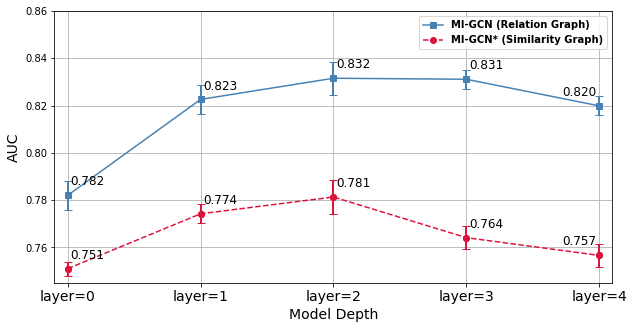

In [1]:
from functools import reduce

from scipy.stats.stats import mode
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from numpy.random import rand
import numpy as np
import math


import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import matplotlib
from matplotlib.pyplot import MultipleLocator
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['savefig.dpi'] = 500
# fig, axs = plt.subplots(1,1)



font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 10,
}

x = np.array([1, 2, 3, 4, 5])
y1 = np.array([0.782, 0.82260, 0.83155, 0.83112, 0.81987])
y11 = np.array([0.782-0.003, 0.82260-0.003, 0.83155-0.0035, 0.83112-0.002, 0.81987-0.002])
y12 = np.array([0.782+0.003, 0.82260+0.003, 0.83155+0.0035, 0.83112+0.002, 0.81987+0.002])
    
y2 = np.array([0.751, 0.7742,0.7813,0.7641,0.7566])
y21 = np.array([0.751-0.0015, 0.7742-0.002,0.7813-0.0035,0.7641-0.0025,0.7566-0.0025])
y22 = np.array([0.751-0.0015, 0.7742+0.002,0.7813+0.0035,0.7641+0.0025,0.7566+0.0025])

df = pd.DataFrame()
df['collaborative graph'] = ['MI-GCN (Relation Graph)']* 15 + ['MI-GCN* (Similarity Graph)']*15
# ['MI-GCN (Relation Graph)','MI-GCN (Relation Graph)','MI-GCN (Relation Graph)','MI-GCN (Relation Graph)','MI-GCN (Relation Graph)','MI-GCN* (Similarity Graph)','MI-GCN* (Similarity Graph)','MI-GCN* (Similarity Graph)','MI-GCN* (Similarity Graph)','MI-GCN* (Similarity Graph)']
df['Layer'] = [1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5]
df['AUC'] = np.concatenate((y1,y11,y12,y2,y21,y22))

# sns.lineplot(x="Layer", y="AUC",hue="collaborative graph", style="collaborative graph", \
#     # markers={'MI-GCN (Relation Graph)':'o', 'MI-GCN* (Similarity Graph)':'o'},\
#     markers=True,\
#          dashes=True, data=df)
c1 = 'steelblue'
c2 = 'crimson'

ax3 = plt.plot(x, y1, linestyle='-', marker='s', color=c1, label='MI-GCN (Relation Graph)')
plt.errorbar(x, y1,
             yerr=[0.006,0.006,0.007,0.004,0.004],
             fmt='o',ecolor=c1,color=c1,elinewidth=2,capsize=4
            )
ax4 = plt.plot(x, y2, linestyle='--', marker='o', color=c2, label='MI-GCN* (Similarity Graph)')
plt.errorbar(x, y2,
             yerr=[0.003,0.004,0.007,0.005,0.005],
             fmt='o',ecolor=c2,color=c2,elinewidth=2,capsize=4
            )

for a,b in zip(x,y1):
    if a == 5:
        plt.text(a-0.15, b+0.003, '%.3f' % b, ha='center', va= 'bottom',fontsize=12)
    else:
        plt.text(a+0.15, b+0.003, '%.3f' % b, ha='center', va= 'bottom',fontsize=12)
for a,b in zip(x,y2):
    if a == 5:
        plt.text(a-0.15, b+0.003, '%.3f' % b, ha='center', va= 'bottom',fontsize=12)
    else:
        plt.text(a+0.15, b+0.003, '%.3f' % b, ha='center', va= 'bottom',fontsize=12)
plt.grid(True)
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
    
plt.ylim(0.745, 0.86)
plt.xlim(0.9, 5.1)
plt.xlabel('Model Depth',font1)
plt.xticks(x,['layer=0', 'layer=1', 'layer=2', 'layer=3', 'layer=4'],fontsize=14)
plt.ylabel('AUC',font1)
plt.legend(loc='upper right',prop=font2)
plt.savefig('./layer.jpg', dpi=500)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


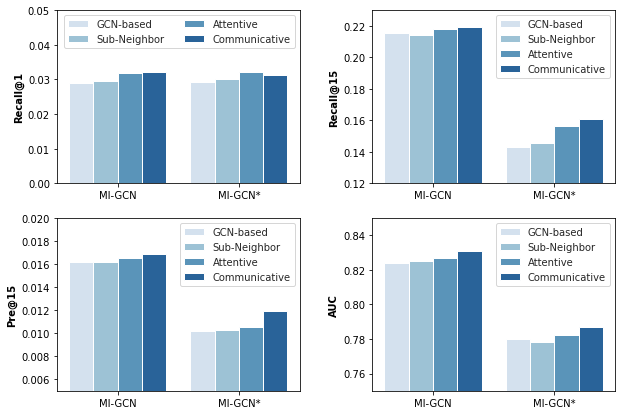

In [1]:
import matplotlib.pylab as plt

import matplotlib
from matplotlib.pyplot import MultipleLocator
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
matplotlib.rcParams['savefig.dpi'] = 500
# fig, axs = plt.subplots(1,1)
matplotlib.rcParams['figure.figsize'] = [10, 7]


font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 10,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 10,
}

d = pd.DataFrame()
d['variant'] = ['GCN-based']*5 + ['Sub-Neighbor']*5 + ['Attentive']*5 + ['Communicative']*5 + ['GCN-based']*5 + ['Sub-Neighbor']*5 + ['Attentive']*5 + ['Communicative']*5
d['p'] = ['Recall@1','Recall@15','Pre@1','Pre@15', 'AUC'] * 8
d['dataset'] = ['MI-GCN']*20 + ['MI-GCN*']*20
d['ret'] = [0.0291,0.2158,0.0324,0.0162,0.824]\
         + [0.0296,0.2142,0.0327,0.0162,0.825]\
         + [0.0320,0.2178,0.0335,0.0165,0.827]\
         + [0.0322,0.2194,0.0349,0.0169,0.831]\
         + [0.0293,0.1432,0.0307,0.0102,0.780]\
         + [0.0300,0.1459,0.0316,0.0103,0.778]\
         + [0.0321,0.1563,0.0350,0.0105,0.782]\
         + [0.0313,0.1608,0.0327,0.0119,0.787]

r1 = d[d['p'] == 'Recall@1']
r15 = d[d['p'] == 'Recall@15']
p1 = d[d['p'] == 'Pre@1']
p15 = d[d['p'] == 'Pre@15']
dauc = d[d['p'] == 'AUC']

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

sns.set_style("whitegrid",{"grid.linestyle": ":"})
# sns.set(style = 'darkgrid')

sns.barplot(x='dataset',y='ret',data=r1,hue='variant',palette='Blues',ax=ax1, capsize=.05, errwidth=1.5)
sns.barplot(x='dataset',y='ret',data=r15,hue='variant',palette='Blues',ax=ax2, capsize=.05, errwidth=1.5)
sns.barplot(x='dataset',y='ret',data=p15,hue='variant',palette='Blues',ax=ax3, capsize=.05, errwidth=1.5)
sns.barplot(x='dataset',y='ret',data=dauc,hue='variant',palette='Blues',ax=ax4, capsize=.05, errwidth=1.5)

ax1.set_ylim(0, 0.05) 
ax1.set_ylabel('Recall@1',font2)

ax2.set_ylim(0.12, 0.23) 
ax2.set_ylabel('Recall@15',font2)

ax3.set_ylim(0.005, 0.02) 
ax3.set_ylabel('Pre@15',font2)

ax4.set_ylim(0.75, 0.85) 
ax4.set_ylabel('AUC',font2)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)
ax4.set_xlabel(None)

ax1.legend(loc='best',prop=font1, ncol=2)
ax2.legend(loc='best',prop=font1, ncol=1)
ax3.legend(loc='best',prop=font1, ncol=1)
ax4.legend(loc='best',prop=font1, ncol=1)
plt.savefig('./mp1.jpg', dpi=500)


In [12]:

m1 = {}
m2 = {}
m3 = {}
m4 = {}
m5 = {}
m6 = {}

ret = [m1,m2,m3,m4,m5,m6]

flag = 0
path="./pp.txt"
lines = open(path, 'r').readlines()
for l in lines:
    inters = [int(i) for i in l.strip().split(' ')]
    if len(inters) == 1:
        flag += 1
        continue
    for j in inters[1:-1]:
        if j in ret[flag].keys():
            ret[flag][j] += 1
        else:
            ret[flag][j] = 1

# for i in range(len(ret)):
#     sorted_i = list(sorted(ret[i].items(), key=lambda x:x[1], reverse=True))
#     print(sorted_i)
#     print('--------------')

from collections import Counter
R = dict(Counter(ret[0]) + Counter(ret[1]) + Counter(ret[2]) + Counter(ret[3]) + Counter(ret[4]) + Counter(ret[5]) )
# print(R)


R_g, R_d = dict(), dict()
for key in R.keys():
    if key >= 3209:
        R_g[key] = R[key]
    else:
        R_d[key] = R[key]

R_d = list(sorted(R_d.items(), key=lambda x:x[1], reverse=True))
R_g = list(sorted(R_g.items(), key=lambda x:x[1], reverse=True))


print(R_d)
print('------------------------')
print(R_g[:30])

[(1917, 724), (250, 630), (158, 544), (34, 468), (24, 380), (458, 250), (1552, 234), (1998, 212), (1937, 196), (2045, 188), (189, 126), (35, 122), (1874, 118), (1576, 114), (1777, 96), (346, 70), (965, 54), (570, 48), (436, 44), (25, 36), (32, 32), (1481, 32), (91, 32), (2511, 28), (576, 28), (1416, 24), (3007, 24), (2496, 24), (92, 24), (1188, 22), (504, 22), (1748, 22), (518, 20), (114, 18), (644, 18), (831, 16), (363, 16), (944, 10), (1531, 8), (1863, 8), (1919, 8), (29, 6), (431, 6), (1578, 6), (2001, 4), (167, 4), (765, 4), (637, 4), (456, 2), (905, 2), (1124, 2), (2349, 2), (1170, 2), (397, 2), (14, 2), (404, 2), (1014, 2), (2860, 2), (372, 2), (2036, 2), (640, 2), (700, 2), (487, 2), (93, 2), (2839, 2), (316, 2), (46, 2), (181, 2), (323, 2), (1789, 2)]
------------------------
[(5324, 19932), (7276, 14934), (7679, 10204), (3342, 7100), (3593, 6580), (6526, 6186), (4247, 5842), (3608, 5712), (6036, 5414), (3444, 5290), (6317, 4428), (4424, 4064), (6013, 3260), (6523, 2998), (5347

In [19]:
cnt1, cnt2 = 0, 0
A = data_generator.adj + data_generator.A
for d in range(0,3209):
    d1_set = set(data_generator.adj.tocsr()[d].tocoo().col)
    for d1 in d1_set:
        g1_set = set(data_generator.adj.tocsr()[d1_set].tocoo().col)
        for g1 in g1_set:
            g_set = set(data_generator.adj.tocsr()[g].tocoo().col)
            for g in g_set:
                cnt1 += 1
                if data_generator.A.tocsr()[d,g] > 0:
                    cnt2 += 1

728
208
760
3446
11408
3382
